# N$_2$H+ cloud grouping

We found that we can fit up to 2 components in N$_2$H+ (1-0) emission. Now we need to assign them.

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import os
import sys
sys.path.append('../')
from setup import *
from skimage import morphology
%matplotlib widget

In [2]:
#files before quality assessment

params1gfile = '../bayes_frame/nested-sampling/NGC1333-SE-mle-x1_filtered.fits'
params2gfile = '../bayes_frame/nested-sampling/NGC1333-SE-mle-x2_filtered.fits'
npeaksfile = '../bayes_frame/nested-sampling/npeaks_cut5_noislands.fits'

#files after quality assessment
params1gfileQA = '../bayes_frame/nested-sampling/NGC1333-SE-mle-x1_filtered_QA.fits'
params2gfileQA = '../bayes_frame/nested-sampling/NGC1333-SE-mle-x2_filtered_QA.fits'
npeaksfileQA = '../bayes_frame/nested-sampling/npeaks_cut5_noislands_QA.fits'

overwrite_cubes = False

In [3]:
params1g, header1g = fits.getdata(params1gfile, header=True)
params2g, header2g = fits.getdata(params2gfile, header=True)
npeaks, npeakshead = fits.getdata(npeaksfile, header=True)
npeaks[np.where(np.isnan(npeaks))] = 0
wcssky = WCS(header1g).celestial
cubehead = fits.getheader(n2hp_1_0_cube+'.fits')

xarray = np.linspace(0, header1g['NAXIS1']-1, header1g['NAXIS1']).astype(int)
yarray = np.linspace(0, header1g['NAXIS2']-1, header1g['NAXIS2']).astype(int)
xmax = header1g['NAXIS1']-1
ymax = header1g['NAXIS2']-1

chanwidth = np.abs(cubehead['CDELT3']) #in km/s
chanerror = chanwidth

In [4]:
#we filter the components that have large errors

if not os.path.exists(params1gfileQA) or not os.path.exists(params2gfileQA) or not os.path.exists(npeaksfileQA) or overwrite_cubes:
    for x in xarray:
        for y in yarray:
            if npeaks[y, x] ==0: continue
            elif npeaks[y, x] == 1:
                if params1g[4,y,x] > chanerror: 
                    for i in range(6): params1g[i, y, x] = np.nan
                    npeaks[y, x] =0
                else: continue
            elif npeaks[y, x] ==2:
                if params2g[7,y,x] > chanerror and params2g[10,y,x] < chanerror: #first component is wrong only
                    # we eliminate the first and save the second
                    for i in range(3): params1g[i,y,x] = params2g[i+3, y, x] 
                    for i in range(3, 6):  params1g[i,y,x] = params2g[i+6, y, x] 
                    for i in range(12): params2g[i, y, x] = np.nan
                    npeaks[y, x] =1
                elif params2g[7,y,x] < chanerror and params2g[10,y,x] > chanerror: #second component is wrong only
                    # we eliminate the second and save the first
                    for i in range(3): params1g[i,y,x] = params2g[i, y, x] 
                    for i in range(3, 6):  params1g[i,y,x] = params2g[i+3, y, x] 
                    for i in range(12): params2g[i, y, x] = np.nan
                    npeaks[y, x] =1
                elif params2g[7,y,x] < chanerror and params2g[10,y,x] < chanerror: continue #both are right
                else: #both are wrong
                    for i in range(12): params2g[i, y, x] = np.nan
                    npeaks[y, x] = 0

    fits.writeto(params1gfileQA, params1g, header1g, overwrite=True)
    fits.writeto(params2gfileQA, params2g, header2g, overwrite=True)
    fits.writeto(npeaksfileQA, npeaks, npeakshead, overwrite=True)
else:
    params1g = fits.getdata(params1gfileQA)
    params2g = fits.getdata(params2gfileQA)
    npeaks = fits.getdata(npeaksfileQA)
    
params1gpermanent = params1g.copy()
params2gpermanent = params2g.copy()
#we will be modifying the parameter cubes so its better to have a copy

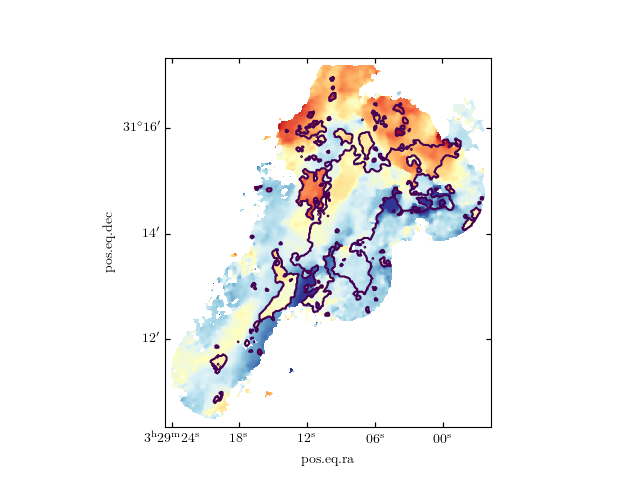

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

ax.imshow(params1g[1], vmin=7, vmax=9, cmap='RdYlBu_r', interpolation='nearest')
ax.imshow(params2g[4], vmin=7, vmax=9, cmap='RdYlBu_r', interpolation='nearest')
ax.contour(npeaks, levels=[1.5])

We can label the Groups in 1 component fit that are separate from each other

In [6]:
mask1g = np.where(npeaks==1, 1, 0)
mask2g = np.where(npeaks==2, 1, 0)
# labelmap, labelnum = morphology.label(mask1g, return_num=True)
# labellist = [labelmap.flatten().tolist().count(i) for i in range(labelnum)]
# labellist.pop(0) # the first label is background
# labelmap = labelmap.astype(float)
# labelmap[np.where(labelmap==0)] = np.nan
# group1 = np.argmax(labellist)+1
# labellist[np.argmax(labellist)] = 1
# group2 = np.argmax(labellist)+1

#the labels of the leftmost and rightmost groups are 1 and 6, respectively

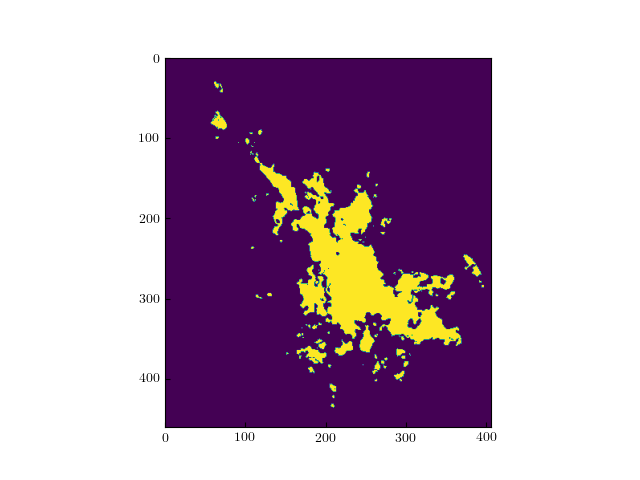

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111) #, projection=wcssky)
showmap = mask2g # np.where(labelmap==group1, 1, 0)
ax.imshow(showmap, cmap='viridis')

## Separation using manual assignment of 2 component groups

We label each individual island of emission and then assign them to the 1 gaussian fit

In [8]:
labelmap2g, labelnum2g = morphology.label(mask2g, return_num=True)
labellist2g = np.linspace(0, labelnum2g-1, labelnum2g)


In [9]:
labellist2g

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78.])

## Separation using weighted distance

Looking at the filtered features in glue, the filament has approximately 3 tiers in velocity. The most redshifted points, vlsr > 8.3 km/s, are almost exclusively on the region of SVS13

In [10]:
#separate the most redshifted points

# vlim = 8.3 
# group_red = np.zeros(np.shape(params1g)) * np.nan
# index_1g = np.where(mask1g) #
# for x, y in zip(index_1g[1], index_1g[0]):
#     if params1g[1, y, x] > vlim:
#         for i in range(6):
#             group_red[i, y, x] = params1g[i, y, x]
#             params1g[i, y, x] = np.nan

In [11]:

#create an array of parameters

paramsgroup1 = np.zeros(np.shape(params1g)) * np.nan
# mask_group1 = np.where(labelmap==group1, 1, 0)

# we first fill the members of the group with 1 Gaussian fit results 
index_group1 = np.where(mask1g) #
for x, y in zip(index_group1[1], index_group1[0]):
    for i in range(6):
            paramsgroup1[i, y, x] = params1g[i, y, x]
            
evaluated = np.zeros(np.shape(npeaks)).astype(int)
evaluated[index_group1] = 1
# paramsgroup2 = np.zeros(np.shape(params1g))
# mask_group2 = np.where(labelmap==group2, 1, 0)

# use the weighted parameter distance from Choudhury et al in prep to assign the values

def weighted_distance(velmap, Tmap, weight, velbase, Tbase):
    deltav = velmap - velbase
    deltaT = Tmap - Tbase
    dp = np.sqrt((weight * deltav)**2 + ((1-weight) * deltaT)**2)
    return dp

def distance_pix(x, y, x0, y0):
    return np.sqrt((x-x0)**2 + (y-y0)**2)

def distance_2G(pixx, pixy, weight, velbase, Tbase):
    vel1 = params2g[1, pixy, pixx]
    T1 = params2g[0, pixy, pixx]
    vel2 = params2g[4, pixy, pixx]
    T2 = params2g[3, pixy, pixx]
    d1 = weighted_distance(vel1, T1, weight, velbase, Tbase)
    d2 = weighted_distance(vel2, T2, weight, velbase, Tbase)
    return d1, d2

def available_neighbors(xx, yy):
    #considering border cases
    
    if xx==0: neighbors_x = [xx+1]
    elif xx==xmax: neighbors_x = [xx-1]
    else: neighbors_x = [xx-1, xx+1]
    
    if yy==0: neighbors_y = [yy+1]
    elif yy==ymax: neighbors_y = [yy-1]
    else: neighbors_y = [yy-1]
    
    # we get all possible combinations of x, y
    combos = np.array(np.meshgrid(neighbors_x, neighbors_y)).T.reshape(-1,2)
    return combos

def get_average_neighbors(xx, yy):
    # border cases
    combos = available_neighbors(xx, yy)
    vel = []
    Tb = []
    for combo in combos:
        vel.append(paramsgroup1[1, combo[1], combo[0]])
        Tb.append(paramsgroup1[0, combo[1], combo[0]])
    
    #normal case
    velbase = np.nanmean(vel)
    Tbase = np.nanmean(Tb)
    return velbase, Tbase
    
def evaluate_distance_neighbors(pixx, pixy, weight):
    velbase, Tbase = get_average_neighbors(pixx, pixy)
    d1, d2 = distance_2G(pixx, pixy, weight, velbase, Tbase)
    if d1 < d2:
        return 0
    # else: return 3
    elif d2 <d1:
        return 1
    else: 
        if np.isnan(d1) and ~np.isnan(d2): return 0
        elif np.isnan(d2) and ~np.isnan(d1): return 1
        else: return np.nan
    
def fill_param_pix_2comp(pixx, pixy, component):
    for i in range(3):
        paramsgroup1[i, pixy,pixx] = params2g[i+3*component, pixy,pixx] #params
        paramsgroup1[i+3, pixy,pixx] = params2g[i+6+3*component, pixy,pixx] #errors
def empty_2g_map(pixx, pixy, component):
    for i in range(3):
        params2g[i+3*component, pixy,pixx] = np.nan #params
        params2g[i+6+3*component, pixy,pixx] = np.nan#errors

In [12]:
x0 = 32#100
y0 = 25#151
wei = 0.5 # more to vel than T
xx, yy = np.meshgrid(xarray, yarray)
distancematrix = distance_pix(xx, yy, x0, y0)

df_aux = pd.DataFrame(data=np.transpose([xx.flatten(), yy.flatten(), distancematrix.flatten(), mask2g.flatten()]), columns=['x', 'y', 'distance', '2g'])
# df_aux = df_aux[df_aux['2g']==1]
df_aux = df_aux.sort_values('distance', ignore_index=True)


In [13]:
missingx = []
missingy = []

for x, y in zip(df_aux['x'].values.astype(int), df_aux['y'].values.astype(int)):
    if evaluated[y,x]: continue
    elif npeaks[y, x]==1: 
        print('this should not happen')
        continue 
    else:
        index_selected = evaluate_distance_neighbors(x, y, wei)
        
        if np.isnan(index_selected): 
            missingx.append(x)
            missingy.append(y)
            continue
        evaluated[y, x] = 1
        fill_param_pix_2comp(x, y, index_selected)
        empty_2g_map(x, y, index_selected)
        

/tmp/ipykernel_36344/2975193718.py:62: RuntimeWarning: Mean of empty slice
  velbase = np.nanmean(vel)
/tmp/ipykernel_36344/2975193718.py:63: RuntimeWarning: Mean of empty slice
  Tbase = np.nanmean(Tb)


In [14]:
# for x, y in zip(df_aux['x'].values.astype(int), df_aux['y'].values.astype(int)):
#     if evaluated[y,x]: continue
#     elif npeaks[y, x]==1: 
#         print('this should not happen')
#         continue 
#     else:
#         index_selected = evaluate_distance_neighbors(x, y, wei)
#         if np.isnan(index_selected): continue
#         fill_param_pix_2comp(x, y, index_selected)
        

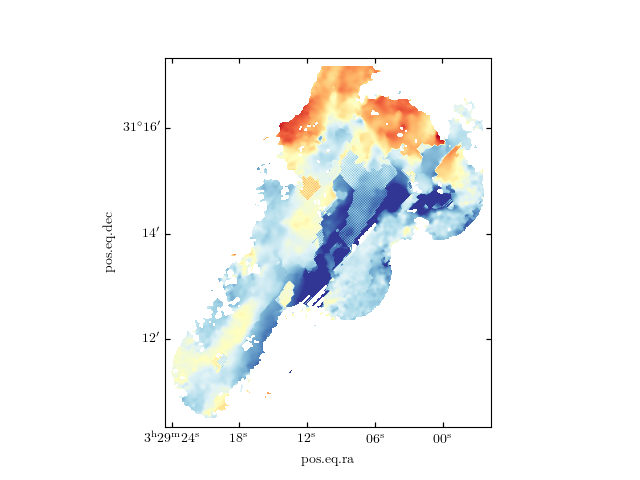

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)
showmap = paramsgroup1[1]
ax.imshow(showmap, vmin=7, vmax=9, cmap='RdYlBu_r') #I think we will have to make it with the groups


In [16]:
# fits.writeto('group1_test.fits', paramsgroup1, header1g, overwrite=True)

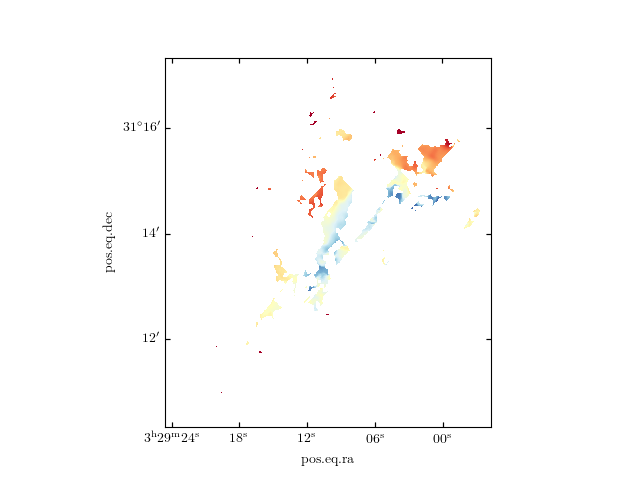

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)
showmap = params2g[4]
ax.imshow(showmap, vmin=7, vmax=9, cmap='RdYlBu_r') #I think we will have to make it with the groups


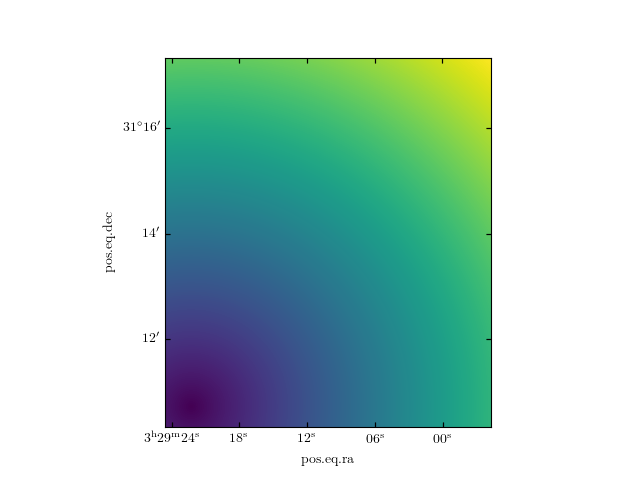

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)
showmap = distancematrix
ax.imshow(showmap) #I think we will have to make it with the groups
